In [15]:
import yfinance as yf
import numpy as np
import pandas as pd
import riskfolio as rp
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [71]:
print(rp.__version__) 

7.0.0


In [69]:
assets = {
    'SPY': 'SP 500',
    'VWRD.L': 'MSCI WORLD',
    '^FCHI': 'CAC 40',
    '^GDAXI': 'DAX 40',
    '^N225': 'NIKKEI 225',
    'BTC-USD': 'BTC',
    'DOGE-USD': 'DOGE',
    'ETH-USD': 'ETH',
    'XRP-USD': 'XRP',
    'ADA-USD': 'ADA',
    'GC=F': 'GOLD',
    'SI=F': 'SILVER',
    'BND': 'US BOND',
    'IXUS': 'WORLD EX-US',
    'TLT': 'US TREASURY',
    'VWO': 'EMERGING MARKETS',
    'BNDX': 'WORLD BOND',
    'VYM': 'HIGH DIVIDEND',
    'VNQ': 'REAL ESTATE',
}

data = yf.download(list(assets.keys()), start='2022-01-01', end='2024-01-01', interval='1d')

if isinstance(data.columns, pd.MultiIndex):  # Si MultiIndex, corriger
    data.columns = pd.MultiIndex.from_tuples([(col[0], assets.get(col[1], col[1])) for col in data.columns])
    data = data.xs("Close", axis=1, level=0)  # Garde uniquement "Close"
else:
    data.rename(columns=assets, inplace=True)  # Si Index simple, pas besoin de MultiIndex

data.columns

[*********************100%***********************]  19 of 19 completed


Index(['ADA', 'US BOND', 'WORLD BOND', 'BTC', 'DOGE', 'ETH', 'GOLD',
       'WORLD EX-US', 'SILVER', 'SP 500', 'US TREASURY', 'REAL ESTATE',
       'EMERGING MARKETS', 'MSCI WORLD', 'HIGH DIVIDEND', 'XRP', 'CAC 40',
       'DAX 40', 'NIKKEI 225'],
      dtype='object')

In [ ]:
data


                 ADA    US BOND  WORLD BOND           BTC      DOGE  \
Date                                                                  
2022-01-01  1.376975        NaN         NaN  47686.812500  0.173035   
2022-01-02  1.377584        NaN         NaN  47345.218750  0.174403   
2022-01-03  1.321637  76.495430   49.648544  46458.117188  0.170088   
2022-01-04  1.311658  76.486313   49.657578  45897.574219  0.168803   
2022-01-05  1.236002  76.222794   49.558254  43569.003906  0.159420   
...              ...        ...         ...           ...       ...   
2023-12-27  0.633535  71.035324   47.590816  43442.855469  0.093579   
2023-12-28  0.617422  70.862289   47.428062  42627.855469  0.091884   
2023-12-29  0.608494  70.698898   47.265316  42099.402344  0.091038   
2023-12-30  0.601964        NaN         NaN  42156.902344  0.090148   
2023-12-31  0.594205        NaN         NaN  42265.187500  0.089472   

                    ETH         GOLD  WORLD EX-US     SILVER      SP 500  \


In [68]:
returns = data[assets.values()].pct_change().dropna()
returns

              SP 500  MSCI WORLD    CAC 40    DAX 40  NIKKEI 225       BTC  \
Date                                                                         
2022-01-05 -0.019202    0.000000  0.008057  0.007376    0.001036 -0.050734   
2022-01-06 -0.000939   -0.016561 -0.017178 -0.013503   -0.028784 -0.009366   
2022-01-07 -0.003953   -0.002044 -0.004163 -0.006497   -0.000327 -0.037141   
2022-01-08  0.000000    0.000000  0.000000  0.000000    0.000000  0.004236   
2022-01-09  0.000000    0.000000  0.000000  0.000000    0.000000  0.004257   
...              ...         ...       ...       ...         ...       ...   
2023-12-27  0.001808    0.008260  0.000396  0.002148    0.011271  0.021694   
2023-12-28  0.000378    0.002605 -0.004842 -0.002420   -0.004205 -0.018760   
2023-12-29 -0.002895   -0.000335  0.001064  0.002999   -0.002250 -0.012397   
2023-12-30  0.000000    0.000000  0.000000  0.000000    0.000000  0.001366   
2023-12-31  0.000000    0.000000  0.000000  0.000000    0.000000

In [83]:
port = rp.Portfolio(returns=returns)
hc_port = rp.HCPortfolio(returns=returns)


stats = port.assets_stats(method_mu="hist", method_cov="hist")


               SP 500    MSCI WORLD        CAC 40   DAX 40  NIKKEI 225  \
weights  2.902034e-07  2.285078e-07  2.271293e-07  4.90482   33.960708   

              BTC          DOGE           ETH     XRP           ADA  \
weights  0.891698  1.573208e-09  5.958060e-08  1.7966  1.499106e-07   

              GOLD        SILVER       US BOND   WORLD EX-US   US TREASURY  \
weights  51.199085  1.466631e-08  3.739271e-09  2.415297e-07  2.454891e-08   

         EMERGING MARKETS    WORLD BOND  HIGH DIVIDEND   REAL ESTATE  
weights      2.139626e-07  5.723487e-09       7.247087  2.525386e-07  

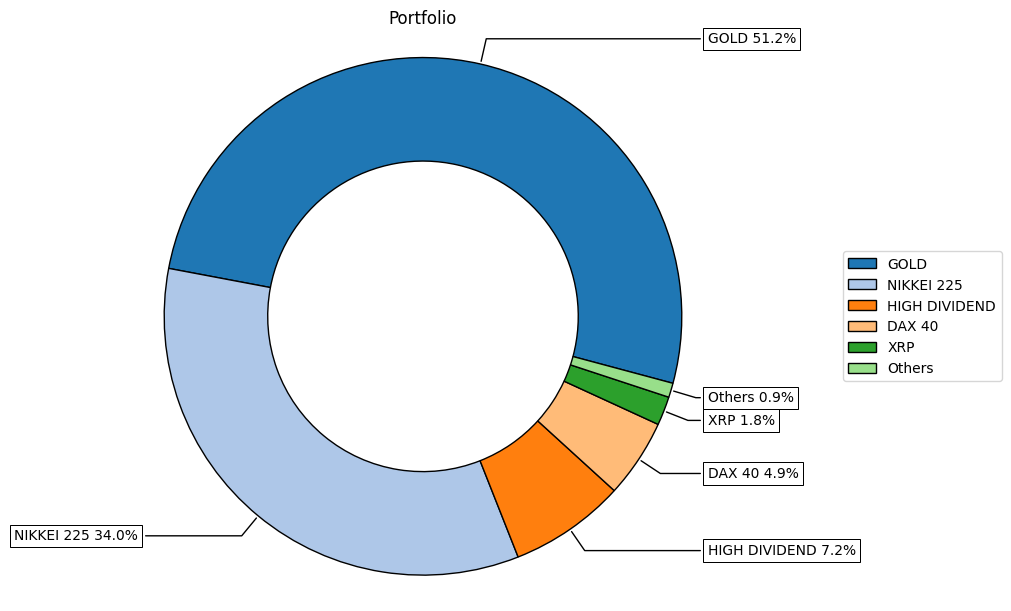

In [84]:
w1 = port.optimization(model='Classic', rm='MV', obj='Sharpe', rf=0, l=0, hist=True) # Sharpe, MinRisk, MaxRet

w2 = port.rp_optimization(model='Classic', rm='MV', rf=0, b=None, hist=True)

w3 = hc_port.optimization(
    model='NCO',
    codependence='pearson',
    obj='Sharpe',
    rm='MV',
    rf=0,
    linkage='single'
)

ws = port.efficient_frontier(model='Classic', rm='MV', points=30, rf=0, hist=True)


# w1: classic sharpe optimization
# w2: risk parity optimization (equal risk contribution)
# w3: Nested Clustered Optimization

w = w3

display(w.T*100)
ax = rp.plot_pie(w=w, title='Portfolio', others=0.01, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

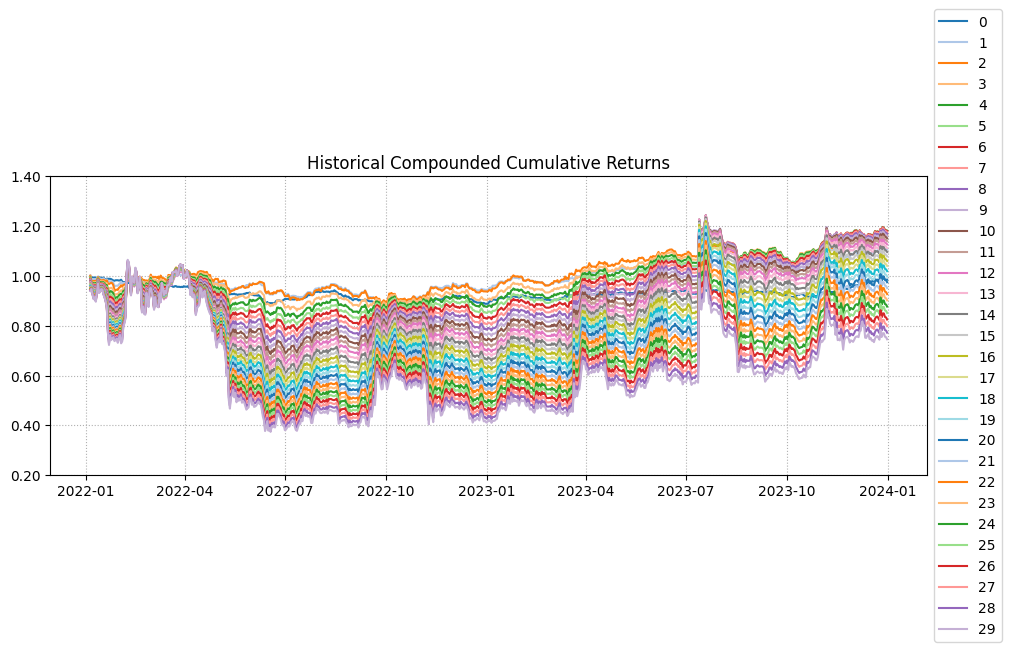

In [85]:
ax = rp.plot_series(returns=returns,w=ws,cmap='tab20',height=6,width=10,ax=None)

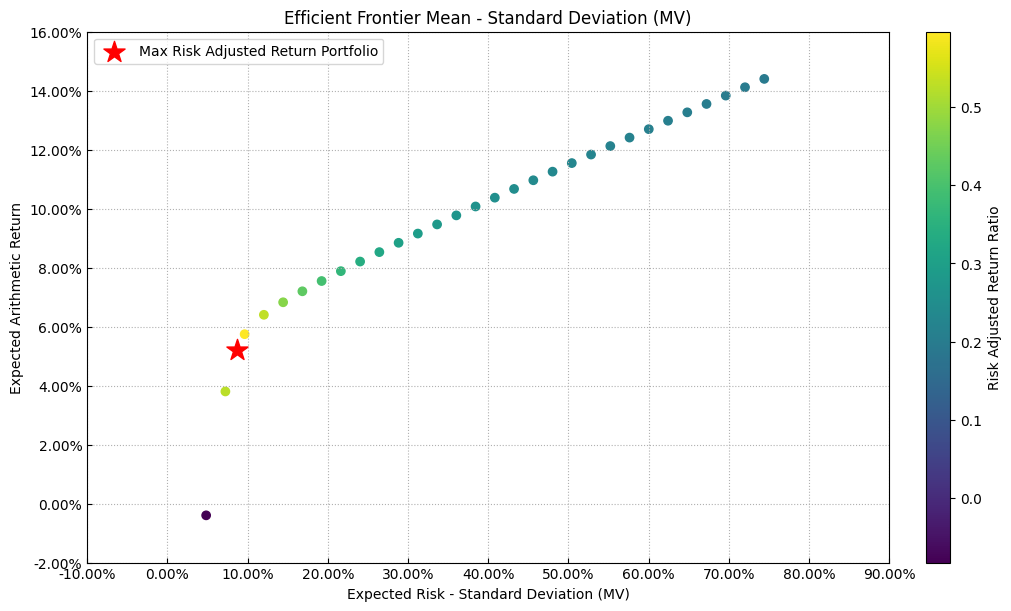

In [86]:
label = 'Max Risk Adjusted Return Portfolio'
mu = port.mu
cov = port.cov
returns = port.returns

ax = rp.plot_frontier(w_frontier=ws,mu=mu,cov=cov,returns=returns,rm="MV",rf=0,alpha=0.05,cmap='viridis',w=w,label=label,marker='*',s=16,c='r',height=6,width=10,t_factor=252,ax=None)

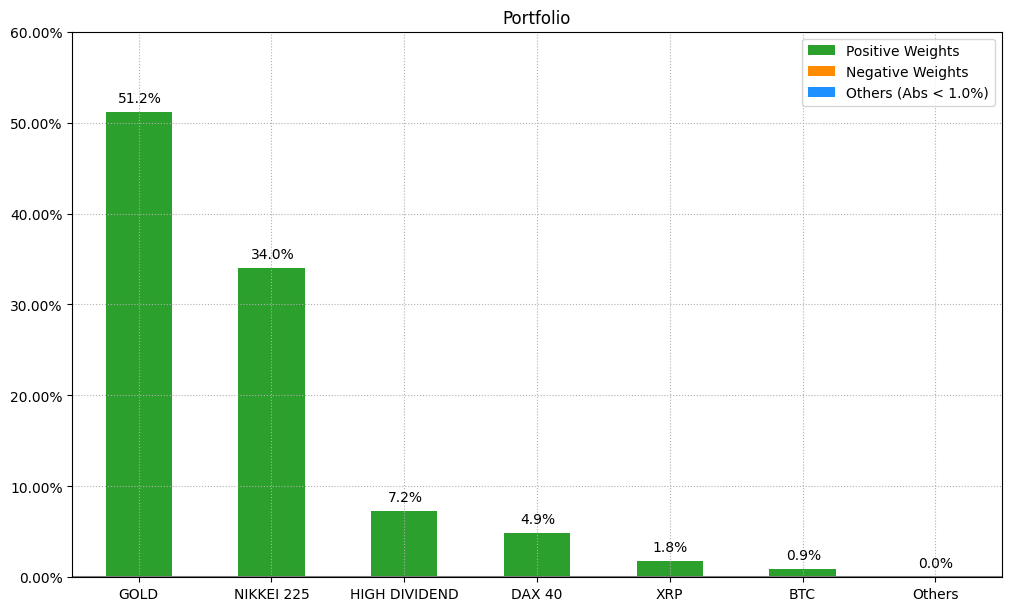

In [87]:
ax = rp.plot_bar(w,title='Portfolio',kind="v",others=0.05,nrow=25,height=6,width=10,ax=None)

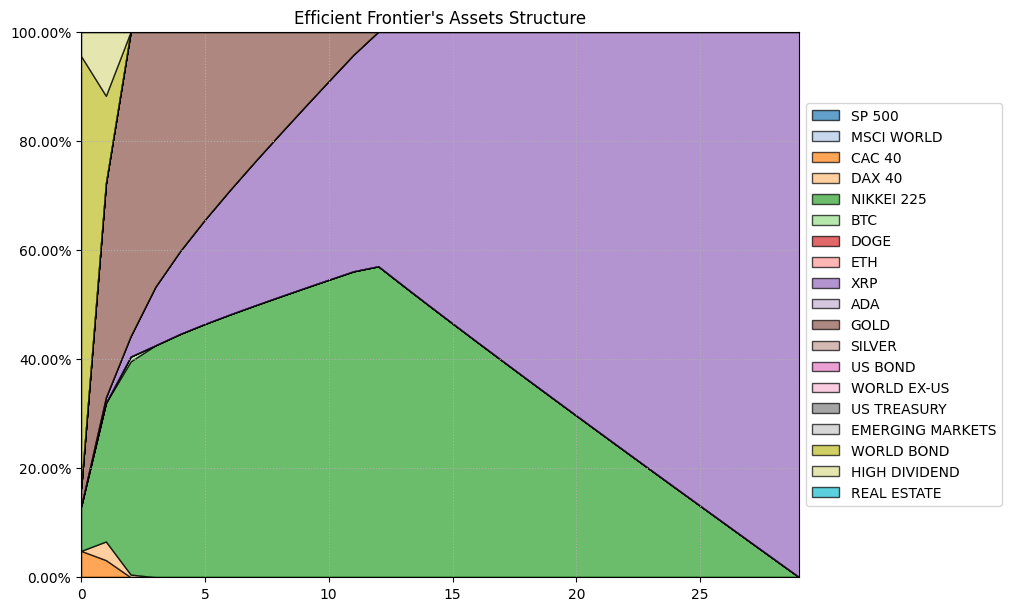

In [88]:
ax = rp.plot_frontier_area(w_frontier=ws,cmap="tab20",height=6,width=10,ax=None)

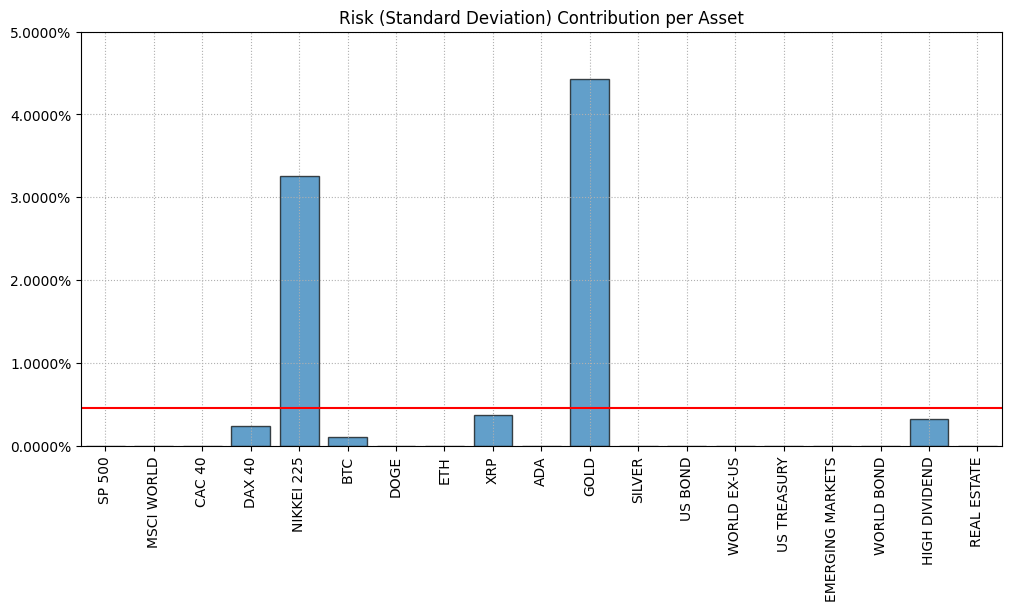

In [89]:
ax = rp.plot_risk_con(w=w,cov=cov,returns=returns,rm="MV",rf=0,alpha=0.05,color="tab:blue",height=6,width=10,t_factor=252,ax=None)

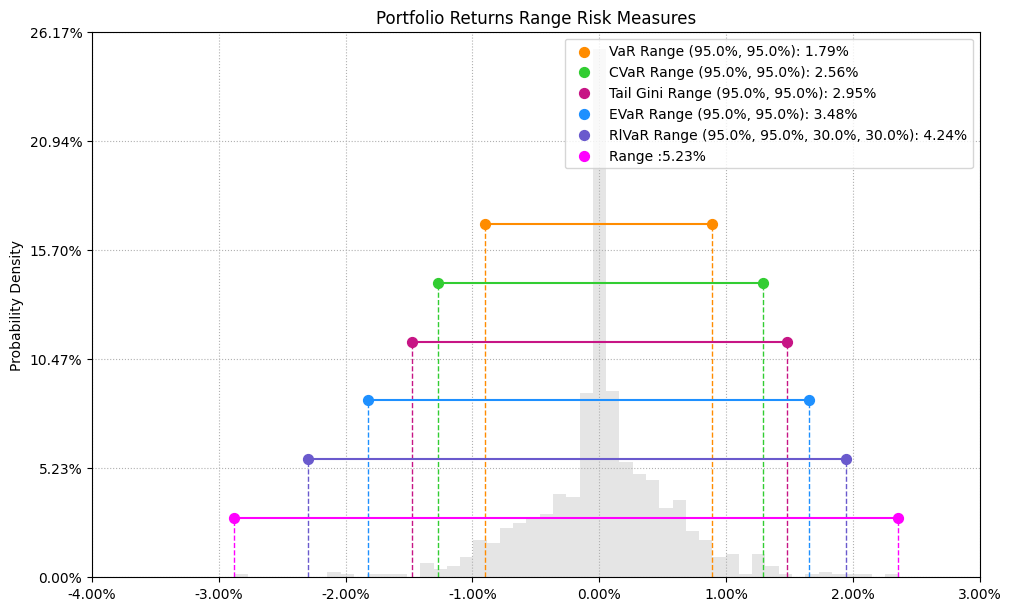

In [90]:
ax = rp.plot_range(returns=returns,w=w,alpha=0.05,a_sim=100,beta=None,b_sim=None,bins=50,height=6,width=10,ax=None)

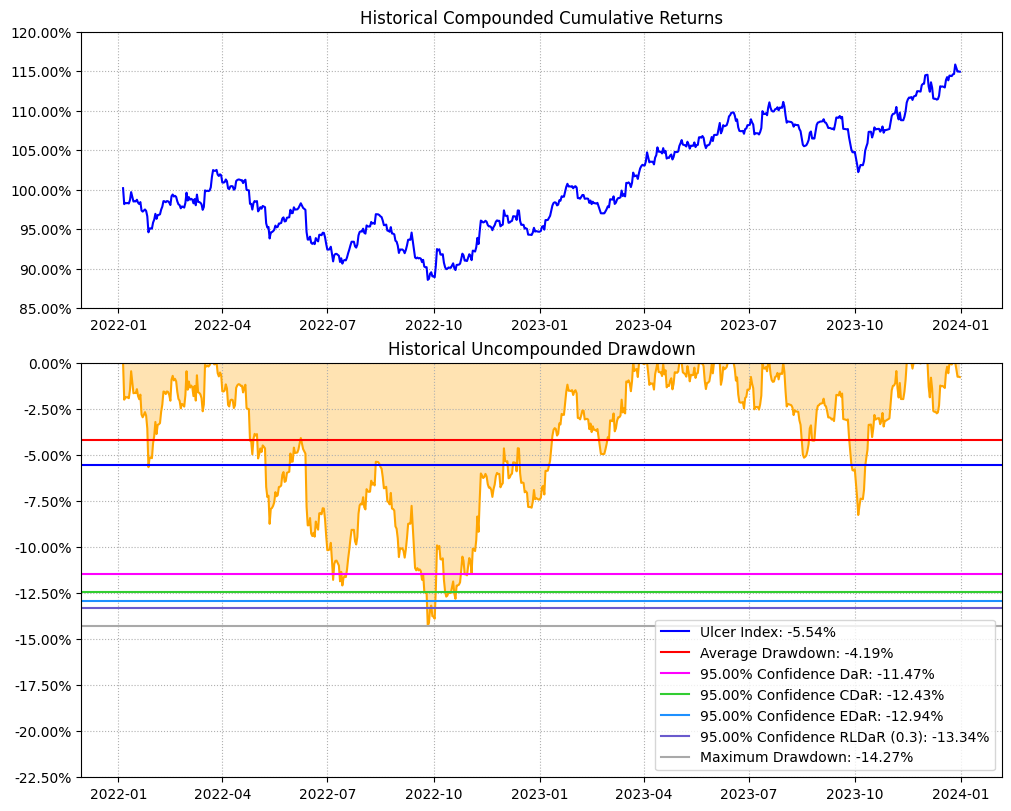

In [91]:
ax = rp.plot_drawdown(returns=returns,w=w,alpha=0.05,height=8,width=10,ax=None)

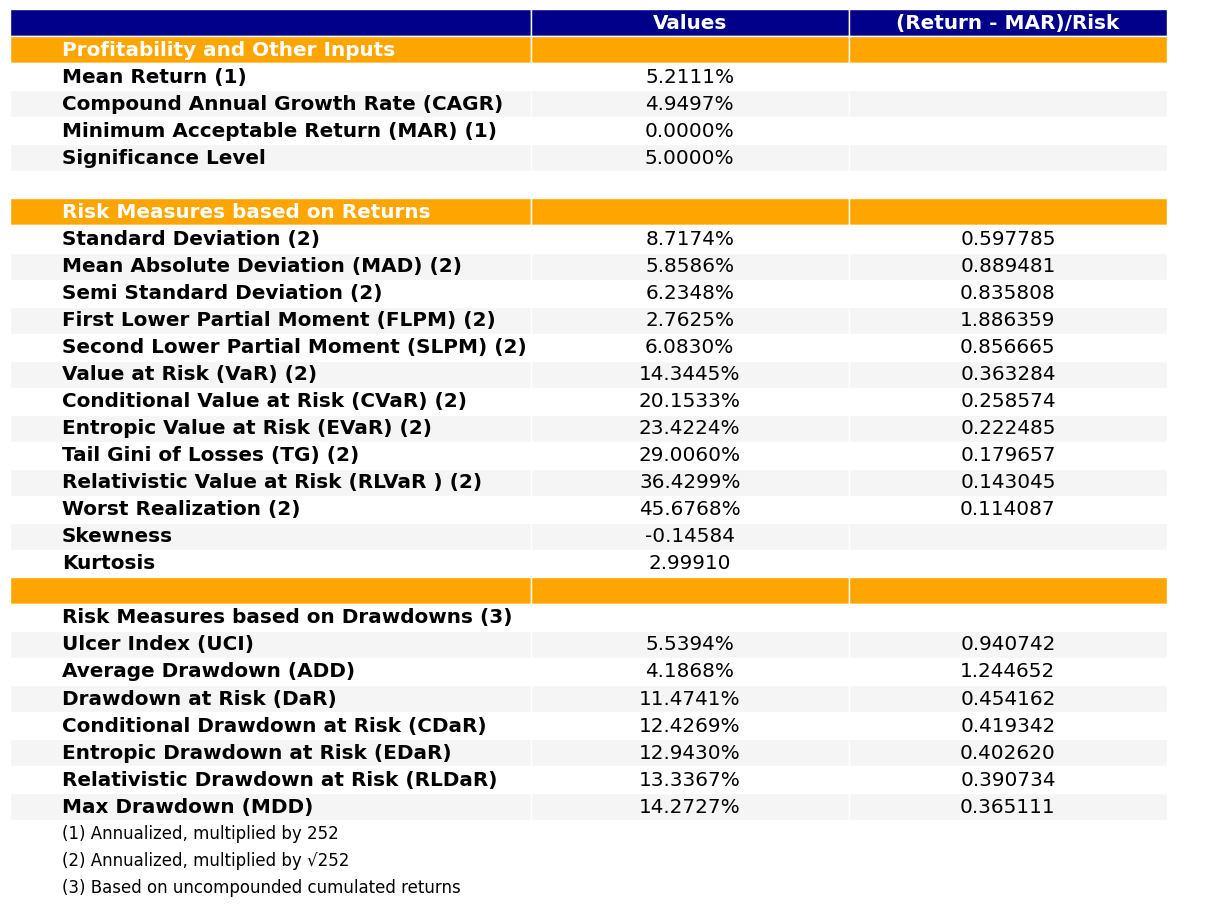

In [92]:
ax = rp.plot_table(returns=returns,w=w,MAR=0,alpha=0.05,ax=None)

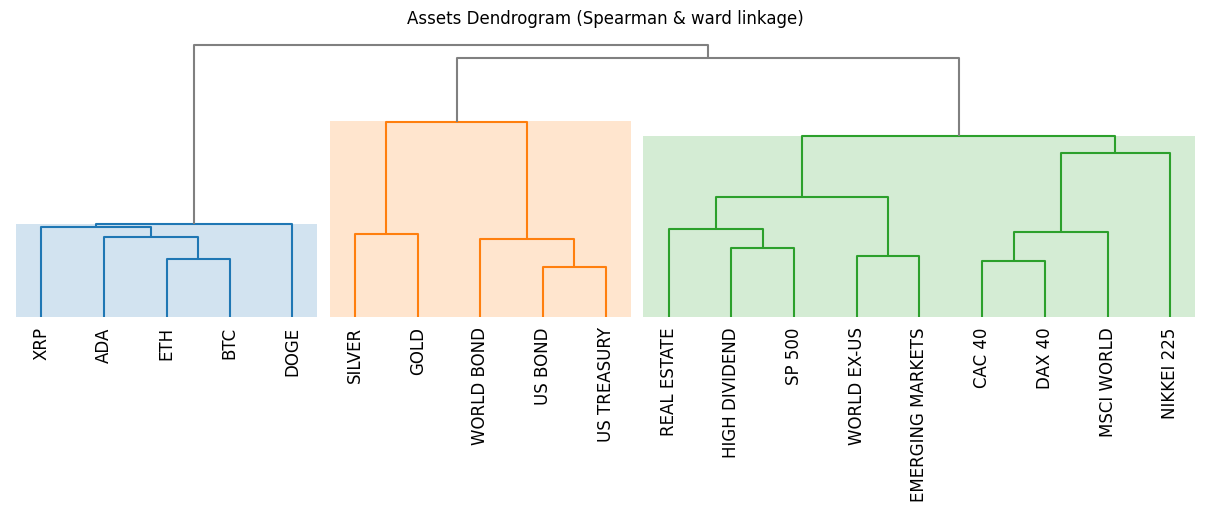

In [93]:
ax = rp.plot_dendrogram(returns=returns,codependence='spearman',linkage='ward',k=None,max_k=10,leaf_order=True,ax=None)

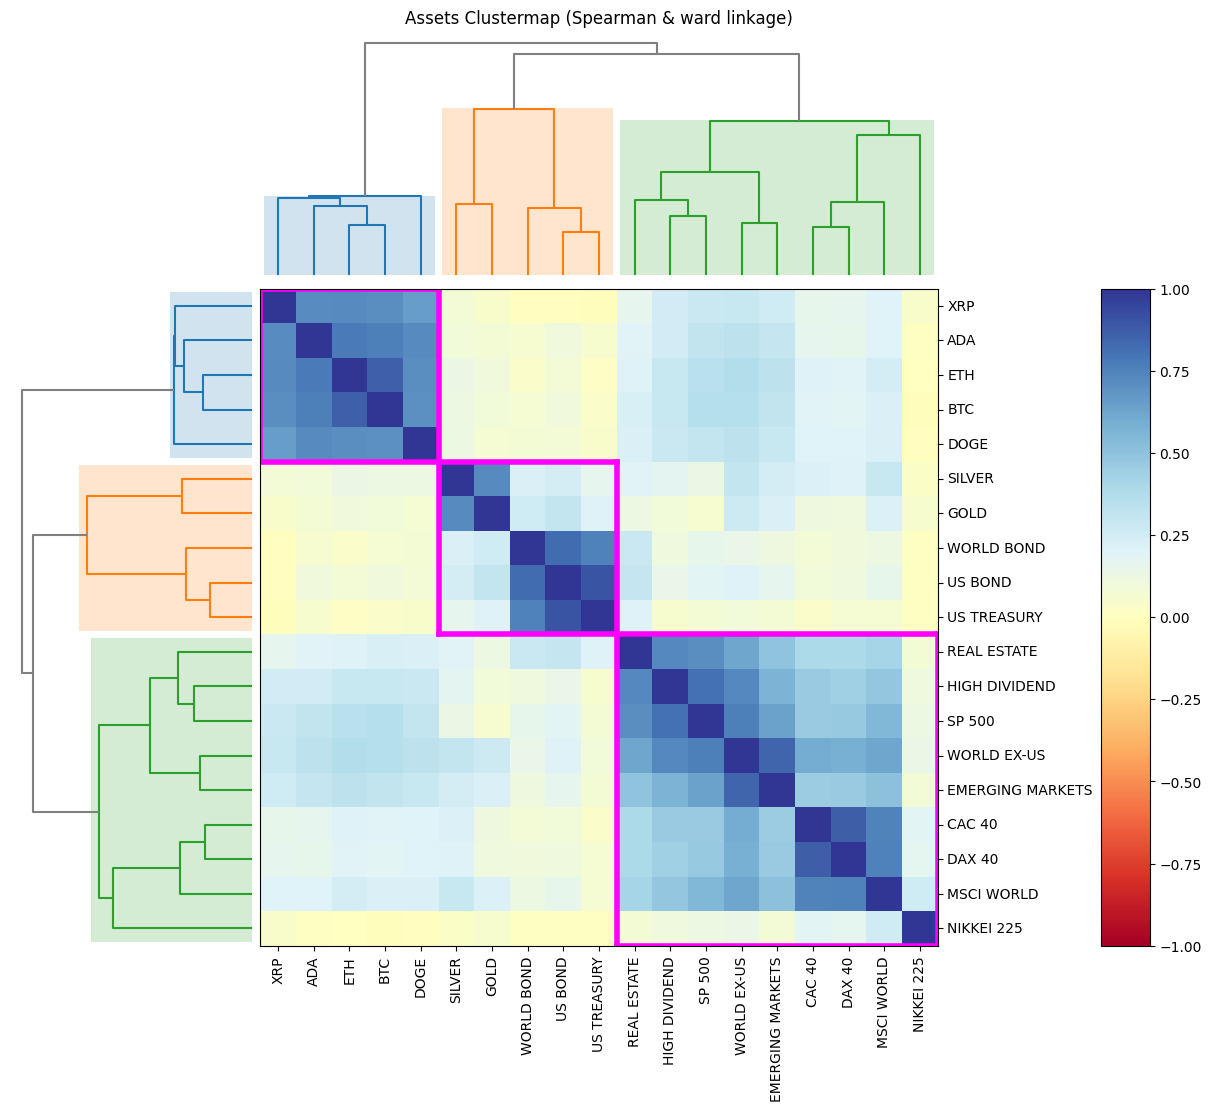

In [94]:
ax = rp.plot_clusters(returns=returns,codependence='spearman',linkage='ward',k=None,max_k=10,leaf_order=True,dendrogram=True,ax=None)

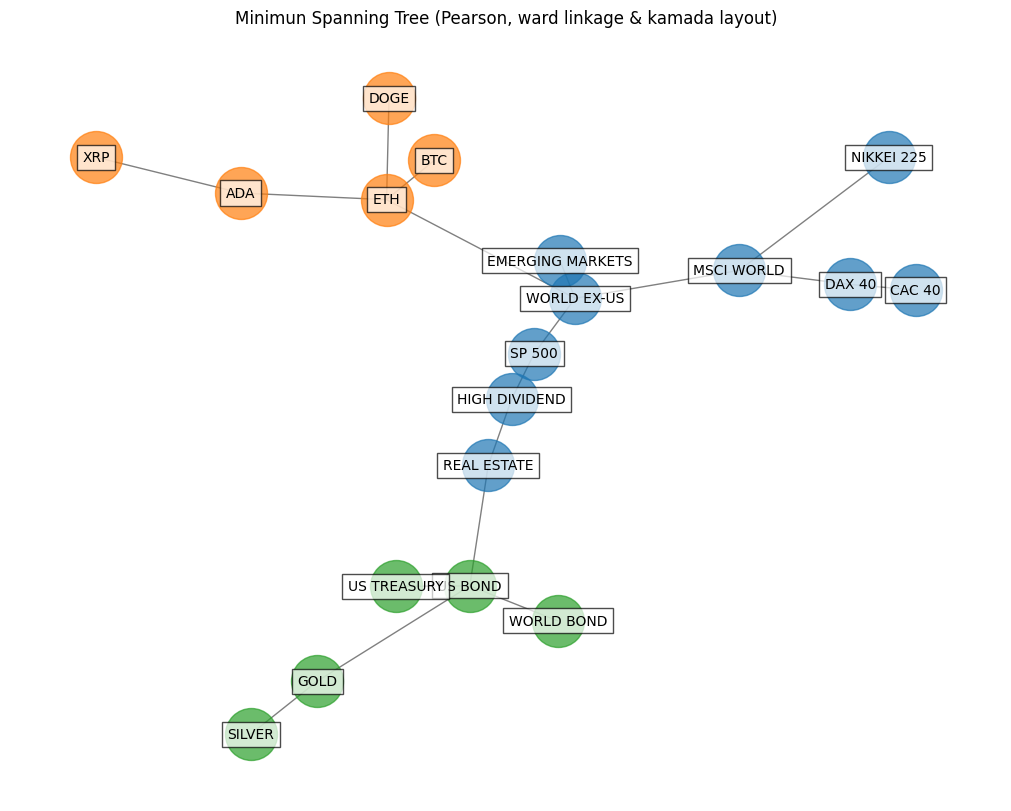

In [95]:
ax = rp.plot_network(returns=returns,codependence="pearson",linkage="ward",k=None,max_k=10,alpha_tail=0.05,leaf_order=True,kind='kamada',ax=None)

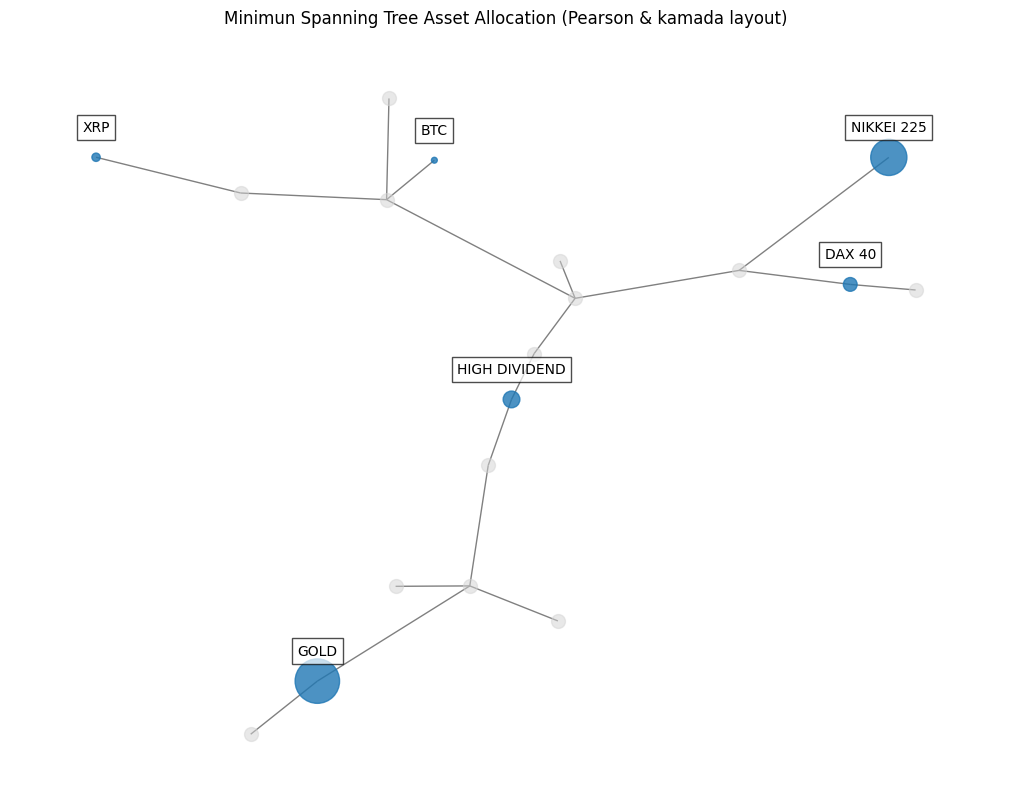

In [96]:
ax = rp.plot_network_allocation(returns=returns,w=w,codependence="pearson",linkage="ward",alpha_tail=0.05,leaf_order=True,kind='kamada',ax=None)